In [1]:
from torch import optim
import torch.utils.data as data
from setting_model import *
import numpy as np
import os

CUDA Device Count: 1
CUDA Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# Model instantiation
# forward_model = model
#forward_model = FC_Net_2D().to(device)

iteration = 0
interval = 100
batch_size = 5
lr = 0.0005     # 3e-4
epoch = 5000
iter_num = []
losses = {'err_train': [], 'err_test': [], 'loss_train': [], 'loss_test': []}

In [3]:
# Gets the relevant file path
data_root = os.getcwd()

train_trajectory_path = os.path.join(data_root, "Train_Data_Fig", "trajectory_292_662.csv")
assert os.path.exists(train_trajectory_path), "{} path does not exist.".format(train_trajectory_path)

test_trajectory_path = os.path.join(data_root, "Train_Data_Fig", "trajectory_33_662.csv")
assert os.path.exists(test_trajectory_path), "{} path does not exist.".format(test_trajectory_path)

# Save the updated weights file
#save_dir = os.path.join(data_root, "weight_optim")
#assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

In [4]:
# Loader Data
train_numpy = np.loadtxt(train_trajectory_path, delimiter=",")
train_input = torch.FloatTensor(train_numpy[:, 0:60]).to(device)
train_label = torch.FloatTensor(train_numpy[:, 60:660]).to(device)
train_input = train_input*1e6
train_label = train_label*1e6
train_dataset = data.TensorDataset(train_input, train_label)
data_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)    # 提取训练数据集并加载

test_numpy = np.loadtxt(test_trajectory_path, delimiter=",")
test_input = torch.FloatTensor(test_numpy[:, 0:60]).to(device)
test_label = torch.FloatTensor(test_numpy[:, 60:660]).to(device)                               # 提取测试数据集
test_input = test_input*1e6
test_label = test_label*1e6

In [5]:
train_numpy.shape

(292, 662)

In [6]:
# 明确DBPN的主要用于图片扩充分辨率--因此60-600的映射按道理来说是有效果的--实际上也确实有效果
# 但是前一段4-60的映射不仅仅只是扩充分辨率--需要更细节的突出映射关系--考虑不使用DBPN网络
# 第二段: 60-600的映射


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv2 = torch.sub(conv2, identity)        # 做减法
        conv3 = self.conv3(conv2)

        out = torch.add(conv3, conv1)             # 做加法

        return out
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.PReLU(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv2 = torch.sub(conv2, identity)      # 做减法
        conv3 = self.conv3(conv2)               

        out = torch.add(conv3, conv1)           # 做加法

        return out
    
class ResNet(nn.Module):
    def __init__(self, bilinear=False):
        super(ResNet, self).__init__()
        
        # The first layer
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # The second layer
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 1, kernel_size=1),
            nn.ReLU(),
        )
        self.M_layer2 = UpBlock(1, 1)                                           # (N, 128, 300)
        #self.pooling1 = nn.ConvTranspose1d(64, 64, kernel_size=3, padding = 1)       # (N, 128, 100)
        self.M_layer3 = DownBlock(1, 1)                                          # (N, 256, 100)
        #self.pooling2 = nn.ConvTranspose1d(1, 1, kernel_size=3, padding = 1)        # (N, 256, 1)
        self.fc_1 = torch.nn.Sequential(
        nn.Linear(60, 3200),
        nn.ReLU(),
        nn.Linear(3200, 1600),
        nn.ReLU(),
        nn.Linear(1600, 800),
        nn.ReLU(),
        nn.Linear(800, 600)
        )
    def forward(self, x):
        x = x.view(-1, 1, 60)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.M_layer2(x)
        x = self.M_layer3(x)
        x = self.M_layer2(x)
        x = self.M_layer3(x)                 # 双重上下采样层
        x = x.view(-1, 60)
        out = self.fc_1(x)
        return out
    
forward_model = ResNet().to(device)

In [7]:
a = torch.ones((10, 60)).to(device)
b = forward_model(a)
b.shape

torch.Size([10, 600])

In [8]:
# Training process
def train():
    optimizer = optim.Adam(forward_model.parameters(), lr=lr)           # 添加正则化避免过拟合weight_decay=3e-5
    criterion = nn.MSELoss(reduction='mean')

    for t in range(epoch):
        for step, item in enumerate(data_loader):
            # train
            train_input, train_label = item
            train_predict = forward_model(train_input)
            loss_train = criterion(train_predict, train_label)
            
            global iteration                      # 声明全局变量， 不声明全局变量会报错
            if iteration % interval == 0:
                # test
                test_predict = forward_model(test_input)
                loss_test = criterion(test_predict, test_label)
                losses['loss_train'].append(loss_train.cpu().detach().numpy())
                losses['loss_test'].append(loss_test.cpu().detach().numpy())

                # compute and print the absolute error
                train_out = train_predict - train_label
                train_error = np.abs(train_out.cpu().detach().numpy()).mean()
                test_out = test_predict - test_label
                test_error = np.abs(test_out.cpu().detach().numpy()).mean()
                losses['err_train'].append(train_error)
                losses['err_test'].append(test_error)
                
                # 需要补充判断当Train_loss和Test_loss的最小时，保存此时的训练模型

                print('iteration: {}'.format(iteration))
                print('train_loss: {:.4}, test_loss: {:.4}'.
                      format(loss_train, loss_test))
                print('train_error: {:.4}, test_error: {:.4}'.
                      format(train_error, test_error))

                iter_num.append(iteration)


            # update parameters
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            iteration += 1

In [9]:
train()

iteration: 0
train_loss: 0.3456, test_loss: 0.4231
train_error: 0.4585, test_error: 0.5212
iteration: 100
train_loss: 0.2228, test_loss: 0.2445
train_error: 0.3743, test_error: 0.3768
iteration: 200
train_loss: 0.08562, test_loss: 0.1848
train_error: 0.2168, test_error: 0.3178
iteration: 300
train_loss: 0.01493, test_loss: 0.08379
train_error: 0.09769, test_error: 0.1953
iteration: 400
train_loss: 0.05769, test_loss: 0.07664
train_error: 0.1627, test_error: 0.1821
iteration: 500
train_loss: 0.02599, test_loss: 0.07894
train_error: 0.1198, test_error: 0.1764
iteration: 600
train_loss: 0.03273, test_loss: 0.04835
train_error: 0.1428, test_error: 0.1482
iteration: 700
train_loss: 0.006792, test_loss: 0.02762
train_error: 0.06464, test_error: 0.1149
iteration: 800
train_loss: 0.01568, test_loss: 0.02017
train_error: 0.09942, test_error: 0.09679
iteration: 900
train_loss: 0.01308, test_loss: 0.01983
train_error: 0.08958, test_error: 0.1024
iteration: 1000
train_loss: 0.01783, test_loss: 0.0

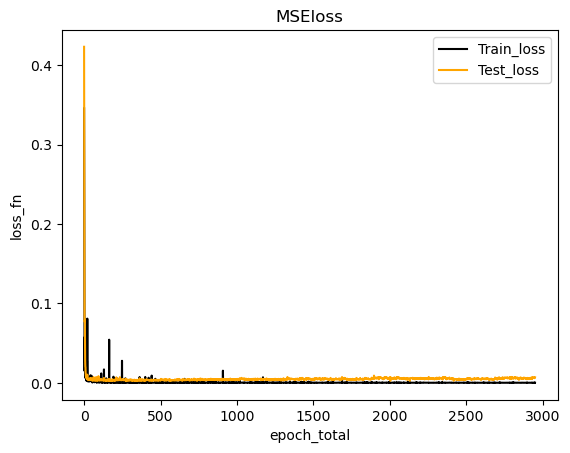

In [10]:
# 过拟合
# MSEloss curve
Len = len(losses['loss_train'])
epoch_total = np.linspace(0, Len, Len)
plt.title('MSEloss')
plt.plot(epoch_total, losses['loss_train'],color="black", label='Train_loss')
plt.plot(epoch_total, losses['loss_test'],color="orange", label='Test_loss')
plt.legend(loc='upper right')
plt.xlabel('epoch_total')
plt.ylabel('loss_fn')
plt.show()

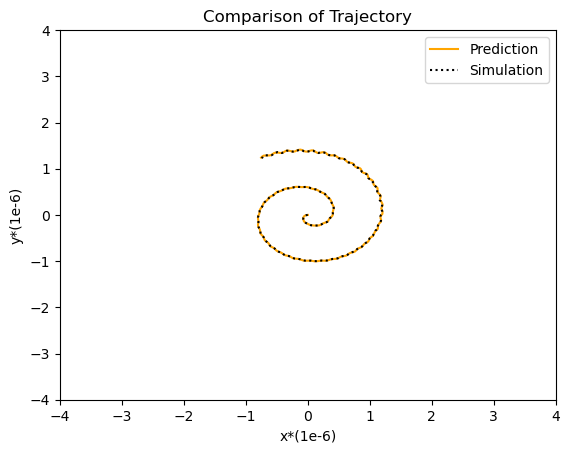

In [11]:
# 损失小于0.001----预测效果就会很好

# plot_train_data
c = 82               # 82
valid_input = train_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 600)               
valid_label = train_label[c].cpu().detach().numpy().reshape(1, 600)                                    
valid_predict = valid_predict.reshape(600,)
valid_label = valid_label.reshape(600,)
#print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:300], valid_predict[300:600], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:300], valid_label[300:600], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()

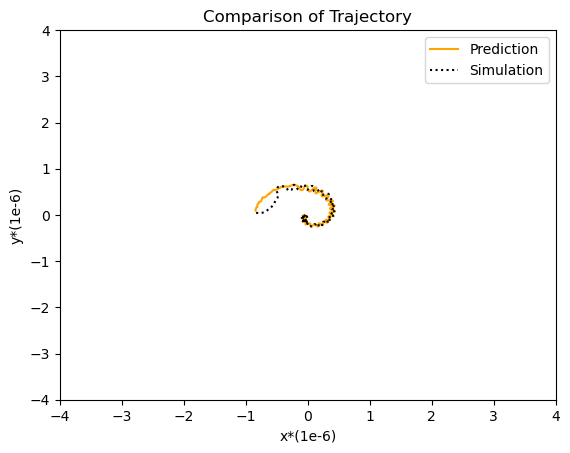

In [21]:
# plot_train_data
c = 6               # 6未能完整转圈
valid_input = test_input[c:c+1]
valid_predict = forward_model(valid_input).view(-1).cpu().detach().numpy().reshape(1, 600)               
valid_label = test_label[c].cpu().detach().numpy().reshape(1, 600)                                    
valid_predict = valid_predict.reshape(600,)
valid_label = valid_label.reshape(600,)
#print(valid_input)

plt.title('Comparison of Trajectory')
plt.plot(valid_predict[0:300], valid_predict[300:600], color="orange", label='Prediction', linestyle='-')
plt.plot(valid_label[0:300], valid_label[300:600], color="black", label='Simulation', linestyle=':')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel('x*(1e-6)')
plt.ylabel('y*(1e-6)')
plt.show()

In [23]:
# 保存更新后的模型
# Save the updated weights file
save_dir = os.path.join(data_root, "weight_optim")
assert os.path.exists(save_dir), "{} path does not exist.".format(save_dir)

torch.save(forward_model.state_dict(),save_dir + '\\forward_phase2.pt')

In [14]:
"""
# 保存MSEloss数据
A = np.zeros((2809, 3)) 
loss_train = losses['loss_train']
loss_test = losses['loss_test']

# list转化为ndarray
epoch_total = epoch_total.reshape(2809,)                       # 第0列训练次数为x数据
loss_train = np.array(loss_train).reshape(2809,)            
loss_test = np.array(loss_test).reshape(2809,)                 # 第1，2列为训练和测试损失

# 保存数据
A[:, 0] = epoch_total
A[:, 1] = loss_train
A[:, 2] = loss_test
filename1 = os.path.join(data_root, "trajectory_test_phase1.csv")
np.savetxt(filename1, A, delimiter=',')"""

'\n# 保存MSEloss数据\nA = np.zeros((2809, 3)) \nloss_train = losses[\'loss_train\']\nloss_test = losses[\'loss_test\']\n\n# list转化为ndarray\nepoch_total = epoch_total.reshape(2809,)                       # 第0列训练次数为x数据\nloss_train = np.array(loss_train).reshape(2809,)            \nloss_test = np.array(loss_test).reshape(2809,)                 # 第1，2列为训练和测试损失\n\n# 保存数据\nA[:, 0] = epoch_total\nA[:, 1] = loss_train\nA[:, 2] = loss_test\nfilename1 = os.path.join(data_root, "trajectory_test_phase1.csv")\nnp.savetxt(filename1, A, delimiter=\',\')'